# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Данные для исследования:
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме 
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах(м²)
- locality_name — название населённого пункта
- rooms — число комнат
- total_area — площадь квартиры в квадратных метрах (м²)

## Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

from plotly.subplots import make_subplots
from tqdm.notebook import tqdm

import plotly.io as pio
pio.renderers.default = 'svg'

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    df = pd.read_csv('secret.csv',
                     sep='\t')
except Exception as err:
    print('Ошибка:', err)

In [3]:
df.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1          11.0      2.0   посёлок Шушары           12817.0   
2           8.3      0.0  Санкт-Петербург           21741.0   
3           NaN      0.0  Санкт-Петербург           28098.0   
4          41.0      NaN  Санкт-Петербург           31856.0   

  cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0             16028.0               1.0          482.0               2.0   
1             18603.0               0.0            NaN               0.0   
2             13933.0               1.0           90.0               2.0   
3              6800.0               2.0           84.0               3.0   
4              8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0  

[5 rows x 22 columns]

### Вывод

1. Пропуски есть во многих столбцах, причин может быть несколько:
    * Пользователи сами не заполняли параметры, потому что не знали значение
    * Ошибка при выгрузке данных
    * NaN как эквивалент 0/False - к примеру, не апартаменты.
2. Много столбцов, которые нам не понадобятся в исследовании, так что удалим их

## Предобработка данных


Делаем новый df с теми столбцами, которые нужны для исследования.

In [4]:
df = df.loc[:, ['last_price', 
                     'total_area', 
                     'kitchen_area', 
                     'living_area', 
                     'ceiling_height', 
                     'floor', 
                     'floors_total', 
                     'rooms', 
                     'days_exposition',
                     'first_day_exposition',
                     'locality_name',
                     'cityCenters_nearest', 
                     ]
                ]

df.head()

last_price  total_area  kitchen_area  living_area  ceiling_height  floor  \
0  13000000.0       108.0          25.0         51.0            2.70      8   
1   3350000.0        40.4          11.0         18.6             NaN      1   
2   5196000.0        56.0           8.3         34.3             NaN      4   
3  64900000.0       159.0           NaN          NaN             NaN      9   
4  10000000.0       100.0          41.0         32.0            3.03     13   

   floors_total  rooms  days_exposition first_day_exposition    locality_name  \
0          16.0      3              NaN  2019-03-07T00:00:00  Санкт-Петербург   
1          11.0      1             81.0  2018-12-04T00:00:00   посёлок Шушары   
2           5.0      2            558.0  2015-08-20T00:00:00  Санкт-Петербург   
3          14.0      3            424.0  2015-07-24T00:00:00  Санкт-Петербург   
4          14.0      2            121.0  2018-06-19T00:00:00  Санкт-Петербург   

   cityCenters_nearest  
0              16028.0  
1              18603.0  
2              13933.0  
3               6800.0  
4               8098.0

Напишем функцию, которая вернет нам основную информацию по датафрейму (количество пропусков, тип данных, дубликаты)

In [5]:
def df_info(df):
    display(df.head())
    print()
    print('Проверка на пропущенные значения:')
    display(pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm'))
    print('----------------')
    print()
    print('Проверка типа данных на корректность:')
    print(df.info())
    print('----------------')
    print()
    print('Количество дубликатов:', df.duplicated().sum())

In [6]:
df_info(df)

last_price  total_area  kitchen_area  living_area  ceiling_height  floor  \
0  13000000.0       108.0          25.0         51.0            2.70      8   
1   3350000.0        40.4          11.0         18.6             NaN      1   
2   5196000.0        56.0           8.3         34.3             NaN      4   
3  64900000.0       159.0           NaN          NaN             NaN      9   
4  10000000.0       100.0          41.0         32.0            3.03     13   

   floors_total  rooms  days_exposition first_day_exposition    locality_name  \
0          16.0      3              NaN  2019-03-07T00:00:00  Санкт-Петербург   
1          11.0      1             81.0  2018-12-04T00:00:00   посёлок Шушары   
2           5.0      2            558.0  2015-08-20T00:00:00  Санкт-Петербург   
3          14.0      3            424.0  2015-07-24T00:00:00  Санкт-Петербург   
4          14.0      2            121.0  2018-06-19T00:00:00  Санкт-Петербург   

   cityCenters_nearest  
0              16028.0  
1              18603.0  
2              13933.0  
3               6800.0  
4               8098.0


Проверка на пропущенные значения:


----------------

Проверка типа данных на корректность:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   last_price            23699 non-null  float64
 1   total_area            23699 non-null  float64
 2   kitchen_area          21421 non-null  float64
 3   living_area           21796 non-null  float64
 4   ceiling_height        14504 non-null  float64
 5   floor                 23699 non-null  int64  
 6   floors_total          23613 non-null  float64
 7   rooms                 23699 non-null  int64  
 8   days_exposition       20518 non-null  float64
 9   first_day_exposition  23699 non-null  object 
 10  locality_name         23650 non-null  object 
 11  cityCenters_nearest   18180 non-null  float64
dtypes: float64(8), int64(2), object(2)
memory usage: 2.2+ MB
None
----------------

Количество дубликатов: 0


### Обработка пропусков

В столбце floors total заполнить средним не получится, потому что, к примеру, средняя по этажам будет 12, заполним пропуски значением 12, а в какой-то строке в 'floor' будет указан этаж 20. Пропущенных значений у нас всего 0.4%, поэтому, думаю, их можно просто удалить.

In [7]:
df.dropna(subset=['floors_total'], inplace=True)

Пустые значения в столбце ceiling_height, kitchen_area, living_area заполним таким образом - выделим 4 диапазона данных, просчитаем медиану для каждого диапазона, замерджим таблицу к основному датафрейму и заполним пустые значения новым столбцом.

In [8]:
df['floors_total_cut'] = pd.qcut(df['floors_total'], q=4)

dr = (
    df
        .groupby('floors_total_cut')
        .agg({'ceiling_height':'median'})
        .rename(columns={'ceiling_height':'ceiling_height_median'})
)

df = df.merge(dr, on='floors_total_cut')
df.head()

last_price  total_area  kitchen_area  living_area  ceiling_height  floor  \
0  13000000.0       108.0          25.0         51.0            2.70      8   
1   3350000.0        40.4          11.0         18.6             NaN      1   
2  64900000.0       159.0           NaN          NaN             NaN      9   
3  10000000.0       100.0          41.0         32.0            3.03     13   
4   2890000.0        30.4           9.1         14.4             NaN      5   

   floors_total  rooms  days_exposition first_day_exposition  \
0          16.0      3              NaN  2019-03-07T00:00:00   
1          11.0      1             81.0  2018-12-04T00:00:00   
2          14.0      3            424.0  2015-07-24T00:00:00   
3          14.0      2            121.0  2018-06-19T00:00:00   
4          12.0      1             55.0  2018-09-10T00:00:00   

               locality_name  cityCenters_nearest floors_total_cut  \
0            Санкт-Петербург              16028.0      (9.0, 16.0]   
1             посёлок Шушары              18603.0      (9.0, 16.0]   
2            Санкт-Петербург               6800.0      (9.0, 16.0]   
3            Санкт-Петербург               8098.0      (9.0, 16.0]   
4  городской посёлок Янино-1                  NaN      (9.0, 16.0]   

   ceiling_height_median  
0                   2.65  
1                   2.65  
2                   2.65  
3                   2.65  
4                   2.65

In [9]:
df['total_area_cut'] = pd.qcut(df['total_area'], q=5)

dr = (
    df
        .groupby('total_area_cut')
        .agg({'living_area':'median',
              'kitchen_area':'median'})
        .rename(columns={'living_area':'living_area_median',
                         'kitchen_area':'kitchen_area_median'})
)

df = df.merge(dr, on='total_area_cut')
df.head()

last_price  total_area  kitchen_area  living_area  ceiling_height  floor  \
0  13000000.0       108.0         25.00        51.00            2.70      8   
1  64900000.0       159.0           NaN          NaN             NaN      9   
2  10000000.0       100.0         41.00        32.00            3.03     13   
3  14200000.0       121.0         12.00        76.00            2.75      8   
4   4050000.0        79.1         11.95        45.23            3.00      1   

   floors_total  rooms  days_exposition first_day_exposition  \
0          16.0      3              NaN  2019-03-07T00:00:00   
1          14.0      3            424.0  2015-07-24T00:00:00   
2          14.0      2            121.0  2018-06-19T00:00:00   
3          16.0      3             97.0  2019-01-09T00:00:00   
4          15.0      3            235.0  2018-02-23T00:00:00   

             locality_name  cityCenters_nearest floors_total_cut  \
0          Санкт-Петербург              16028.0      (9.0, 16.0]   
1          Санкт-Петербург               6800.0      (9.0, 16.0]   
2          Санкт-Петербург               8098.0      (9.0, 16.0]   
3          Санкт-Петербург              12843.0      (9.0, 16.0]   
4  деревня Новое Девяткино                  NaN      (9.0, 16.0]   

   ceiling_height_median total_area_cut  living_area_median  \
0                   2.65  (74.9, 900.0]                55.0   
1                   2.65  (74.9, 900.0]                55.0   
2                   2.65  (74.9, 900.0]                55.0   
3                   2.65  (74.9, 900.0]                55.0   
4                   2.65  (74.9, 900.0]                55.0   

   kitchen_area_median  
0                 14.0  
1                 14.0  
2                 14.0  
3                 14.0  
4                 14.0

In [10]:
df.fillna({
    'ceiling_height':df['ceiling_height_median'],
    'living_area':df['living_area_median'],
    'kitchen_area':df['kitchen_area_median']
}, inplace=True)

df.head()

last_price  total_area  kitchen_area  living_area  ceiling_height  floor  \
0  13000000.0       108.0         25.00        51.00            2.70      8   
1  64900000.0       159.0         14.00        55.00            2.65      9   
2  10000000.0       100.0         41.00        32.00            3.03     13   
3  14200000.0       121.0         12.00        76.00            2.75      8   
4   4050000.0        79.1         11.95        45.23            3.00      1   

   floors_total  rooms  days_exposition first_day_exposition  \
0          16.0      3              NaN  2019-03-07T00:00:00   
1          14.0      3            424.0  2015-07-24T00:00:00   
2          14.0      2            121.0  2018-06-19T00:00:00   
3          16.0      3             97.0  2019-01-09T00:00:00   
4          15.0      3            235.0  2018-02-23T00:00:00   

             locality_name  cityCenters_nearest floors_total_cut  \
0          Санкт-Петербург              16028.0      (9.0, 16.0]   
1          Санкт-Петербург               6800.0      (9.0, 16.0]   
2          Санкт-Петербург               8098.0      (9.0, 16.0]   
3          Санкт-Петербург              12843.0      (9.0, 16.0]   
4  деревня Новое Девяткино                  NaN      (9.0, 16.0]   

   ceiling_height_median total_area_cut  living_area_median  \
0                   2.65  (74.9, 900.0]                55.0   
1                   2.65  (74.9, 900.0]                55.0   
2                   2.65  (74.9, 900.0]                55.0   
3                   2.65  (74.9, 900.0]                55.0   
4                   2.65  (74.9, 900.0]                55.0   

   kitchen_area_median  
0                 14.0  
1                 14.0  
2                 14.0  
3                 14.0  
4                 14.0

Все заполнилось, проверим нет ли каких несостыковок.

In [11]:
df.query('living_area >= total_area')

last_price  total_area  kitchen_area  living_area  ceiling_height  \
11374   1900000.0        15.0           8.0         17.0            2.50   
11856   1850000.0        13.0           8.0         17.0            3.40   
11857   1686000.0        13.2           8.0         17.0            2.60   
12655   2350000.0        25.0           8.0         25.0            2.75   
12799   3700000.0        24.2           8.0         24.2            2.75   
14127   1550000.0        15.0           8.0         17.0            2.70   
14167   1400000.0        13.0           8.0         17.0            2.60   

       floor  floors_total  rooms  days_exposition first_day_exposition  \
11374      1           5.0      1             45.0  2018-06-27T00:00:00   
11856      2           5.0      1             24.0  2019-03-11T00:00:00   
11857      1           5.0      1             19.0  2018-12-17T00:00:00   
12655     17          22.0      0             13.0  2017-12-03T00:00:00   
12799     13          19.0      0             74.0  2017-11-10T00:00:00   
14127      1           9.0      1             42.0  2018-08-21T00:00:00   
14167      1           9.0      1            410.0  2017-12-03T00:00:00   

         locality_name  cityCenters_nearest floors_total_cut  \
11374     Сосновый Бор                  NaN     (0.999, 5.0]   
11856  Санкт-Петербург               5483.0     (0.999, 5.0]   
11857  Санкт-Петербург               4165.0     (0.999, 5.0]   
12655   посёлок Мурино                  NaN     (16.0, 60.0]   
12799  Санкт-Петербург              16840.0     (16.0, 60.0]   
14127  Санкт-Петербург              16376.0       (5.0, 9.0]   
14167  Санкт-Петербург              15945.0       (5.0, 9.0]   

       ceiling_height_median  total_area_cut  living_area_median  \
11374                   2.60  (11.999, 37.6]                17.0   
11856                   2.60  (11.999, 37.6]                17.0   
11857                   2.60  (11.999, 37.6]                17.0   
12655                   2.75  (11.999, 37.6]                17.0   
12799                   2.75  (11.999, 37.6]                17.0   
14127                   2.60  (11.999, 37.6]                17.0   
14167                   2.60  (11.999, 37.6]                17.0   

       kitchen_area_median  
11374                  8.0  
11856                  8.0  
11857                  8.0  
12655                  8.0  
12799                  8.0  
14127                  8.0  
14167                  8.0

Плошадь кухни больше общей площади квартиры, чего быть не может. Строк всего (0.02% от всего датафрейма), так что можно удалить, на дальнейшее исследование это не повлияет.

In [12]:
df = df.query('living_area < total_area')

Удаляем ненужные столбцы.

In [13]:
born_to_die = ['floors_total_cut', 'ceiling_height_median', 'total_area_cut', 'living_area_median', 'kitchen_area_median']

df.drop(columns=born_to_die, inplace=True)
df.head()

last_price  total_area  kitchen_area  living_area  ceiling_height  floor  \
0  13000000.0       108.0         25.00        51.00            2.70      8   
1  64900000.0       159.0         14.00        55.00            2.65      9   
2  10000000.0       100.0         41.00        32.00            3.03     13   
3  14200000.0       121.0         12.00        76.00            2.75      8   
4   4050000.0        79.1         11.95        45.23            3.00      1   

   floors_total  rooms  days_exposition first_day_exposition  \
0          16.0      3              NaN  2019-03-07T00:00:00   
1          14.0      3            424.0  2015-07-24T00:00:00   
2          14.0      2            121.0  2018-06-19T00:00:00   
3          16.0      3             97.0  2019-01-09T00:00:00   
4          15.0      3            235.0  2018-02-23T00:00:00   

             locality_name  cityCenters_nearest  
0          Санкт-Петербург              16028.0  
1          Санкт-Петербург               6800.0  
2          Санкт-Петербург               8098.0  
3          Санкт-Петербург              12843.0  
4  деревня Новое Девяткино                  NaN

В столбце с названием населенного пункта нет подходящих значений на замену, поэтому заменим пропущенные значения на пустую строку.

In [14]:
df['locality_name'].fillna('', inplace=True)

Посмотрим, что осталось

In [15]:
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

23% значений пропущено в столбце с расстоянием до центра города. Довольно большое количество пропусков, заполнив их медианой/средним можем серьезно исказить данные. 

Со столбцом days_exposition ситуация схожая, но нам надо будет поменять тип данных на целочисленный, а с пропусками такой возможности не будет. Заполним маркером -1

In [16]:
df['days_exposition'].fillna(-1, inplace=True)

### Замена типа данных

In [17]:
df.dtypes

last_price              float64
total_area              float64
kitchen_area            float64
living_area             float64
ceiling_height          float64
floor                     int64
floors_total            float64
rooms                     int64
days_exposition         float64
first_day_exposition     object
locality_name            object
cityCenters_nearest     float64
dtype: object

Заменить тип данных нужно:
* На int: floors_total, days_exposition. Количество этажей, дней - целые числа, значит int. 
* На datetime: first_day_exposition, потому что дата.

In [18]:
df = df.astype({
    'floors_total':'int',
    'days_exposition':'int',
})

df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])

Проверим еще корректность данных в столбце с названием города/поселка

In [19]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'деревня Новое Девяткино', 'деревня Куттузи',
       'Ломоносов', 'городской посёлок Янино-1', 'Тосно',
       'посёлок Александровская', 'Всеволожск', 'посёлок Шушары',
       'деревня Старая', 'поселок Бугры', 'посёлок Мурино',
       'посёлок Парголово', 'посёлок Стрельна',
       'поселок городского типа имени Свердлова', 'деревня Кудрово',
       'Колпино', 'Сестрорецк', 'Павловск', 'Выборг', 'Кудрово',
       'Гатчина', 'Мурино', 'поселок Мурино', 'Петергоф',
       'деревня Малые Колпаны', 'посёлок Тельмана', 'Пушкин', 'Кингисепп',
       'Коммунар', 'посёлок Бугры', 'Сертолово', 'Кронштадт',
       'Красное Село', 'Зеленогорск', 'Волхов',
       'посёлок городского типа Лебяжье', 'посёлок Металлострой', '',
       'посёлок городского типа имени Морозова', 'Пикалёво',
       'посёлок городского типа Токсово', 'посёлок Репино', 'Волосово',
       'посёлок Новый Свет', 'Отрадное', 'деревня Кальтино', 'Луга',
       'Сланцы', 'посёлок Кикерино', 'поселок г

Данные чистые, приведены к одному типу, исправлять вроде ничего не нужно

### Расчёты

Рассчитываем цену за кв. метр.

In [20]:
df['price_per_meter'] = df['last_price'] / df['total_area']

Добавляем в таблицу день недели, месяц и год публикации объявления.


In [21]:
df['day_publication'] = df['first_day_exposition'].dt.weekday
df['month_publication'] = df['first_day_exposition'].dt.month
df['year_publication'] = df['first_day_exposition'].dt.year

Пишем функцию, которая определяет этаж квартиры.

In [22]:
def find_floor(row):
    if row['floor'] == 1:
        return 'Первый этаж'
    if row['floor'] == row['floors_total']:
        return 'Последний этаж'
    return 'Другой этаж'

In [23]:
df['floor_str'] = df.apply(find_floor, axis=1)

Добавляем соотношение площади кухни и жилой к общей площади.

In [24]:
df['living_to_total_ratio'] = round(df['living_area'] / df['total_area'], 2)
df['kitchen_to_total_ratio'] = round(df['kitchen_area'] / df['total_area'], 2)

In [25]:
df.head()

last_price  total_area  kitchen_area  living_area  ceiling_height  floor  \
0  13000000.0       108.0         25.00        51.00            2.70      8   
1  64900000.0       159.0         14.00        55.00            2.65      9   
2  10000000.0       100.0         41.00        32.00            3.03     13   
3  14200000.0       121.0         12.00        76.00            2.75      8   
4   4050000.0        79.1         11.95        45.23            3.00      1   

   floors_total  rooms  days_exposition first_day_exposition  \
0            16      3               -1           2019-03-07   
1            14      3              424           2015-07-24   
2            14      2              121           2018-06-19   
3            16      3               97           2019-01-09   
4            15      3              235           2018-02-23   

             locality_name  cityCenters_nearest  price_per_meter  \
0          Санкт-Петербург              16028.0    120370.370370   
1          Санкт-Петербург               6800.0    408176.100629   
2          Санкт-Петербург               8098.0    100000.000000   
3          Санкт-Петербург              12843.0    117355.371901   
4  деревня Новое Девяткино                  NaN     51201.011378   

   day_publication  month_publication  year_publication    floor_str  \
0                3                  3              2019  Другой этаж   
1                4                  7              2015  Другой этаж   
2                1                  6              2018  Другой этаж   
3                2                  1              2019  Другой этаж   
4                4                  2              2018  Первый этаж   

   living_to_total_ratio  kitchen_to_total_ratio  
0                   0.47                    0.23  
1                   0.35                    0.09  
2                   0.32                    0.41  
3                   0.63                    0.10  
4                   0.57                    0.15

## Исследовательский анализ данных

###  Посмотрим на основные ценообразующие факторы: площадь, цена, число комнат, высота потолков.

Напишем функцию, которая будет возвращать describe и гистограмму с боксплотом, построенные в диапозоне 3 межквартильных размахов

In [26]:
def primary_info(data, column, title):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3-q1
    
    left_border = round(q1 - 3 * iqr, 2)
    right_border = round(q3 + 3 * iqr, 2)
    
    if left_border < data[column].min(): 
        left_border = data[column].min() 
        
    if right_border > data[column].max(): 
        right_border = data[column].max()
    
    fig = px.histogram(data, x=column, marginal="box", title=title,
                       range_x=(left_border, right_border))
    fig.show()

    display(pd.DataFrame(data[column].describe()))

Изучаем площадь квартир.

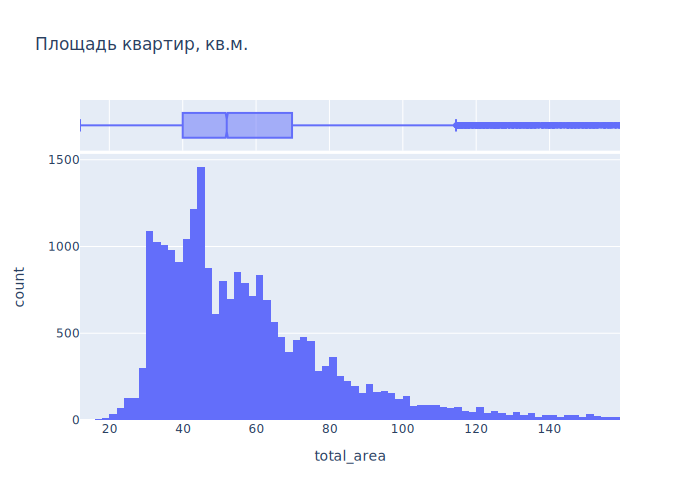

total_area
count  23606.000000
mean      60.353556
std       35.646326
min       12.000000
25%       40.000000
50%       52.000000
75%       69.800000
max      900.000000

In [27]:
primary_info(df, 'total_area', 'Площадь квартир, кв.м.')

Далее изучим цену.

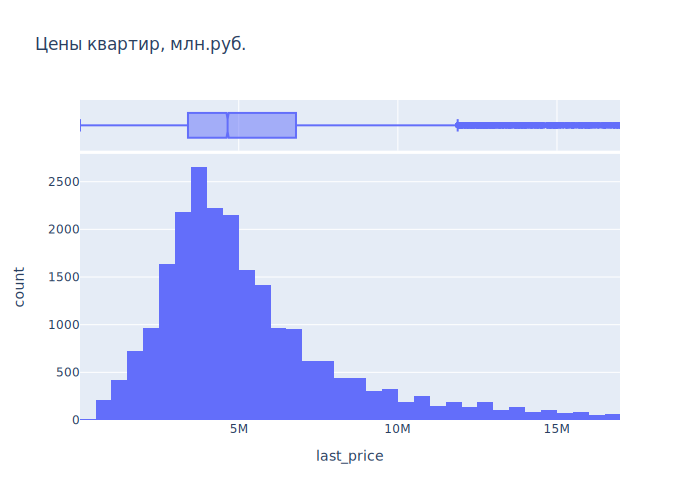

last_price
count  2.360600e+04
mean   6.541883e+06
std    1.090306e+07
min    1.219000e+04
25%    3.405250e+06
50%    4.650000e+06
75%    6.799000e+06
max    7.630000e+08

In [28]:
primary_info(df, 'last_price', 'Цены квартир, млн.руб.')

Изучим число комнат.

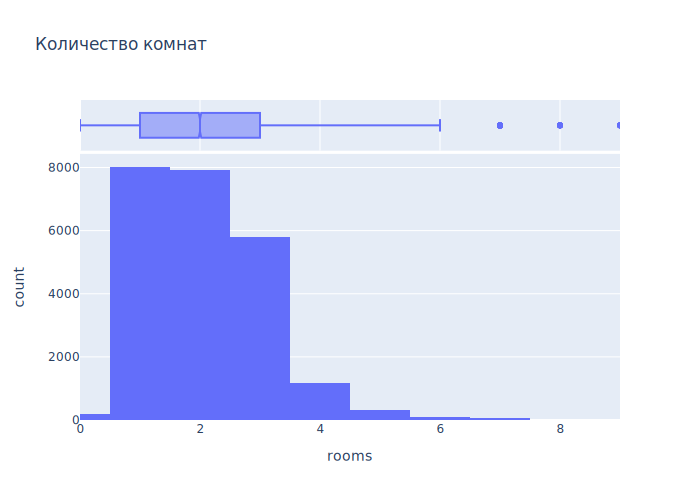

rooms
count  23606.000000
mean       2.071550
std        1.078259
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       19.000000

In [29]:
primary_info(df, 'rooms', 'Количество комнат')

Посмотрим высоту потолков.

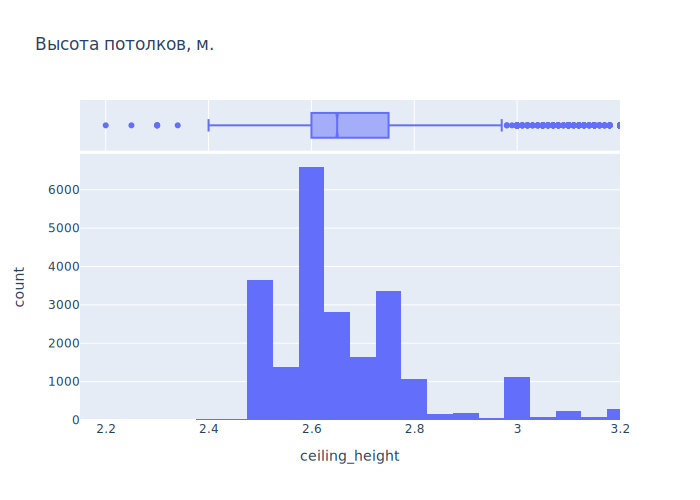

ceiling_height
count    23606.000000
mean         2.723918
std          0.991014
min          1.000000
25%          2.600000
50%          2.650000
75%          2.750000
max        100.000000

In [30]:
primary_info(df, 'ceiling_height', 'Высота потолков, м.')

По каждому параметру много выбросов, в пункте 4.3 всё почистим.

### Изучим время продажи квартиры. Выясним, сколько времени обычно занимает продажа.

*Помним, что мы заполнили пропущенные значения маркером, их нельзя учитывать в анализе*

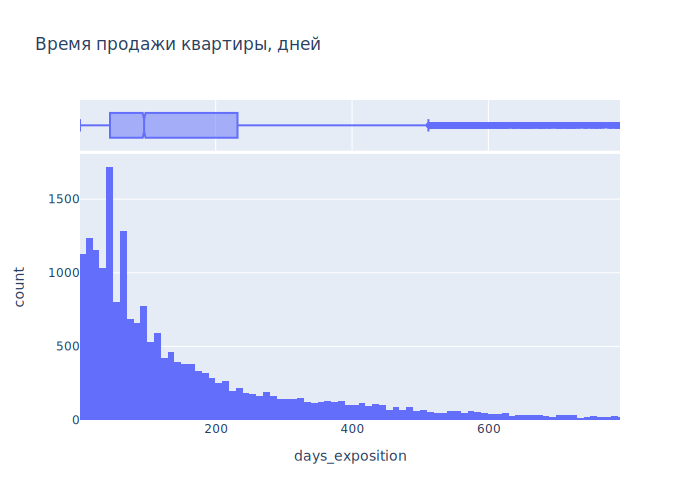

days_exposition
count     20434.000000
mean        180.916120
std         219.703045
min           1.000000
25%          45.000000
50%          95.000000
75%         232.000000
max        1580.000000

In [31]:
primary_info(df.query('days_exposition > 0'), 'days_exposition', 'Время продажи квартиры, дней')

Посмотрим поближе

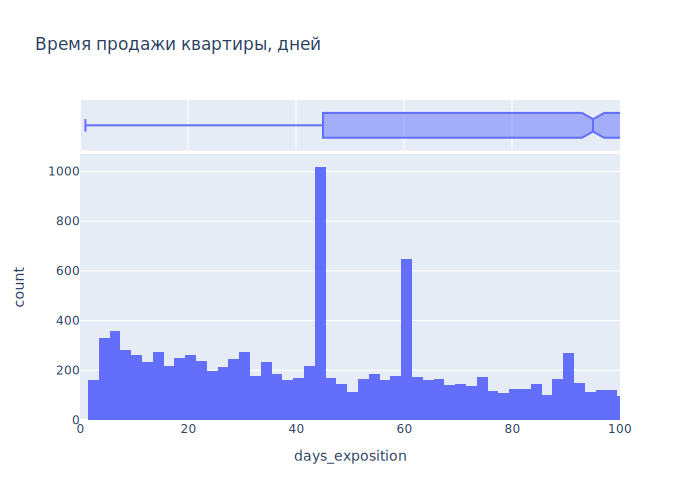

In [32]:
fig = px.histogram(df.query('days_exposition > 0'), x='days_exposition', marginal="box",
                   title='Время продажи квартиры, дней', range_x=(0,100), nbins=1000)
fig.show()

В среднем квартира продается за 50-60 дней, то бишь 2 месяца.

Согласно графикам, будем считать, что продажа прошла слишком быстро, если квартиру продали менее, чем за 3 дня; слишком долгая продажа - это 500 дней и более.

### Уберите редкие и выбивающиеся значения.

Напишем 2 функции: одна будет возвращать границы, по которым мы будем чистить датафрейм от выбросов (я выбрал 1.5 межквартильных размаха), а другая будет чистить наш датафрейм на основе этих границ

In [33]:
def set_border(column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    
    left_border = round(q1 - 1.5 * iqr, 2)
    right_border = round(q3 + 1.5 * iqr, 2)
    
    if left_border < df[column].min(): 
        left_border = df[column].min() 
        
    if right_border > df[column].max(): 
        right_border = df[column].max()
        
    return left_border, right_border

In [34]:
def clear_values(data, column):
    return df.query("@set_border(column)[0] <= column <= @set_border(column)[1]")

Вот как выглядят боксплоты до очистки от выбросов

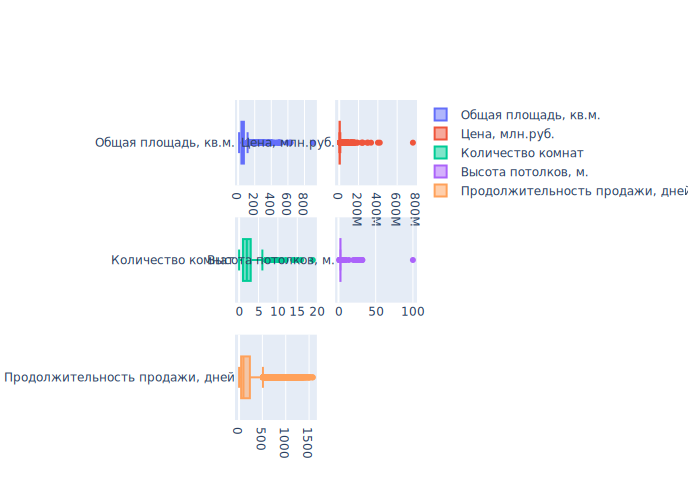

In [35]:
fig = make_subplots(rows=3, cols=2)

fig.add_trace(
    go.Box(x=df['total_area'], name='Общая площадь, кв.м.'), row=1, col=1)
fig.add_trace(
    go.Box(x=df['last_price'], name='Цена, млн.руб.'), row=1, col=2)
fig.add_trace(
    go.Box(x=df['rooms'], name='Количество комнат'), row=2, col=1)
fig.add_trace(
    go.Box(x=df['ceiling_height'], name='Высота потолков, м.'), row=2, col=2)
fig.add_trace(
    go.Box(x=df.query('days_exposition > 0')['days_exposition'], name='Продолжительность продажи, дней'), row=3, col=1)

fig.show()

Теперь пробежимся в цикле по столбцам: площадь, цена, количество комнат, высота потолков и продолжительность объявления в днях, и удалим все значения, которые выходят за границы 1.5 межквартильных размаха

In [36]:
for i in tqdm(['total_area', 'last_price', 'rooms', 'ceiling_height', 'days_exposition']):
    print('Доля удаленных значений после очистки столбца {}: {:.2%}' \
          .format(i, 1-(len(df[(df[i] > set_border(i)[0]) & (df[i] < set_border(i)[1])]) / len(df))))
    df = df[(df[i] > set_border(i)[0]) & (df[i] < set_border(i)[1])]

  0%|          | 0/5 [00:00<?, ?it/s]

Доля удаленных значений после очистки столбца total_area: 5.25%
Доля удаленных значений после очистки столбца last_price: 6.00%
Доля удаленных значений после очистки столбца rooms: 0.92%
Доля удаленных значений после очистки столбца ceiling_height: 7.51%
Доля удаленных значений после очистки столбца days_exposition: 20.37%


Боксплоты после очистки от выбросов

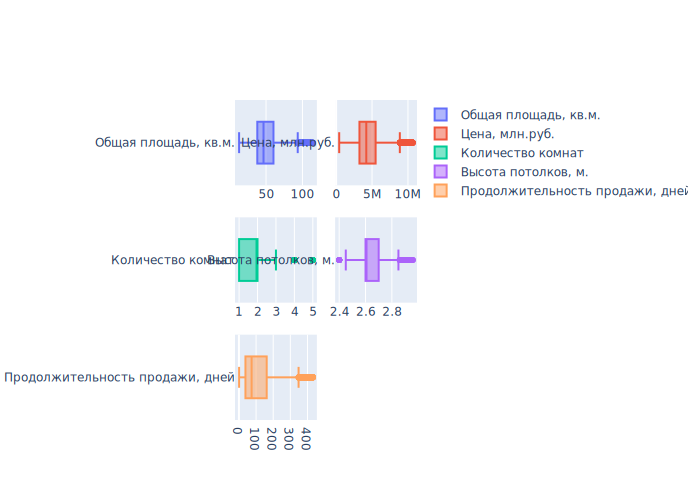

In [37]:
fig = make_subplots(rows=3, cols=2)

fig.add_trace(
    go.Box(x=df['total_area'], name='Общая площадь, кв.м.'), row=1, col=1)
fig.add_trace(
    go.Box(x=df['last_price'], name='Цена, млн.руб.'), row=1, col=2)
fig.add_trace(
    go.Box(x=df['rooms'], name='Количество комнат'), row=2, col=1)
fig.add_trace(
    go.Box(x=df['ceiling_height'], name='Высота потолков, м.'), row=2, col=2)
fig.add_trace(
    go.Box(x=df['days_exposition'], name='Продолжительность продажи, дней'), row=3, col=1)

fig.show()

### Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от площади, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.

Взаиомсвязь данных определим с помощью тепловой карты и диаграммы рассеяния.

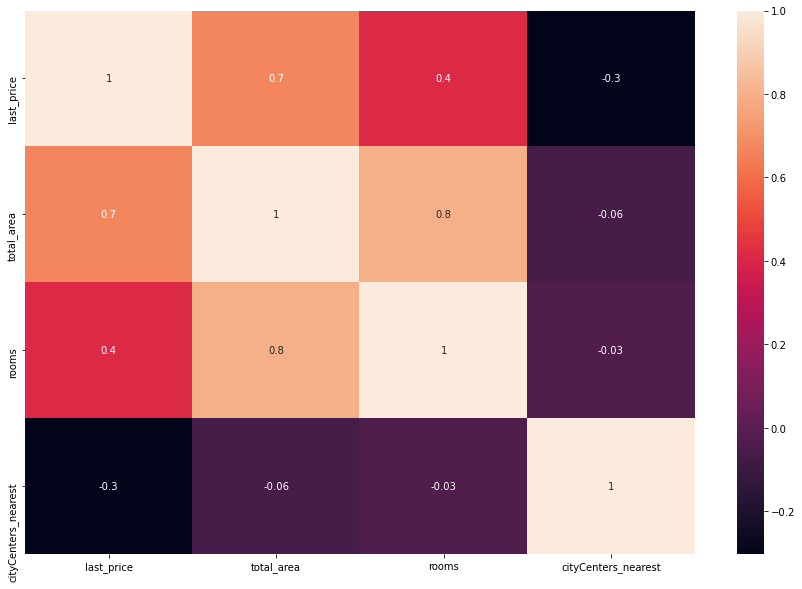

In [38]:
plt.subplots(figsize=(15,10))
sns.heatmap(df[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']].corr(), annot = True, fmt='.1g')
plt.show()

Как и логично, корелляция между ценой и площадью квартиры стремится к 1, то есть чем больше площадь, тем больше цена квартиры. Ситуация с количеством комнат такая же, только корреляция чуть менее тесная (коэф. 0.39). Что касается удаленности от центра, то здесь тоже все логично - коэф. стремится к -1, так как чем больше удаленность от центра, тем меньше цена квартиры, но связь в нашем случае довольно слабая. 

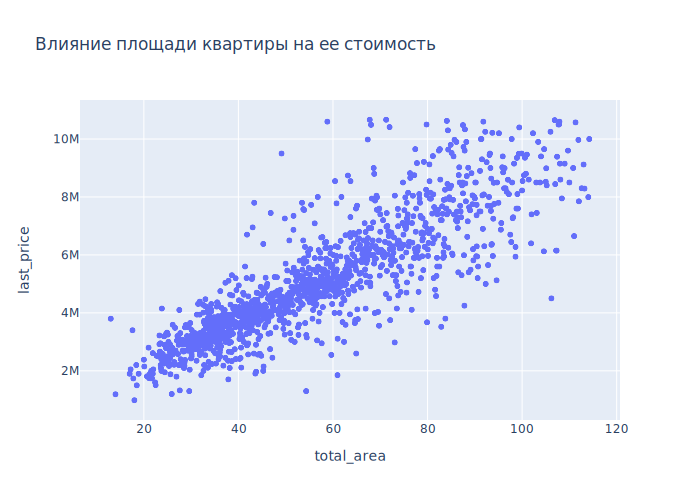

In [39]:
fig = px.scatter(pd.DataFrame(df.groupby('total_area')['last_price'].agg('median').sort_values()).reset_index(),
                 x='total_area', y='last_price', title='Влияние площади квартиры на ее стоимость')
fig.show()

Посмотрим связь с этажами.

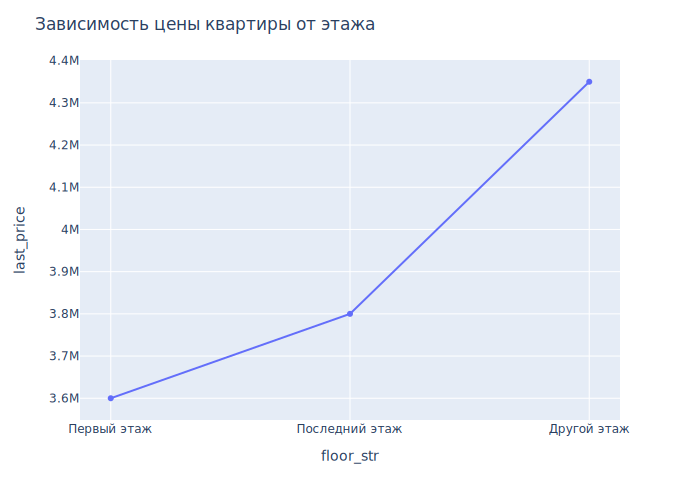

In [40]:
fig = px.scatter(df.groupby('floor_str')['last_price'].median().sort_values().reset_index(),
                 x='floor_str', y='last_price')

fig.update_traces(mode='lines+markers')
fig.update_layout(title='Зависимость цены квартиры от этажа')
fig.show()

Очевидно, что первые и последние этажи дешевле, чем остальные. 

Просмотрим связь с датой публикации.

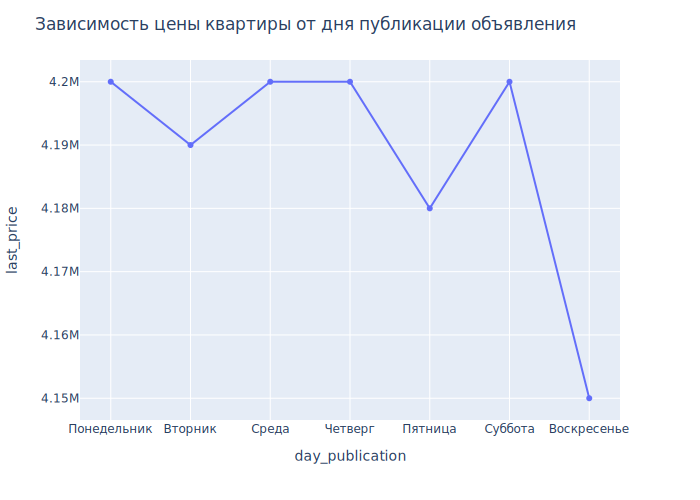

In [41]:
fig = px.scatter(df.groupby('day_publication')['last_price'].median().reset_index(),
                 x='day_publication', y='last_price')

fig.update_traces(mode='lines+markers')
fig.update_layout(title='Зависимость цены квартиры от дня публикации объявления')

for idx in range(len(fig.data)):
    fig.data[idx].x = ['Понедельник','Вторник','Среда', 'Четверг','Пятница','Суббота', 'Воскресенье']
fig.show()

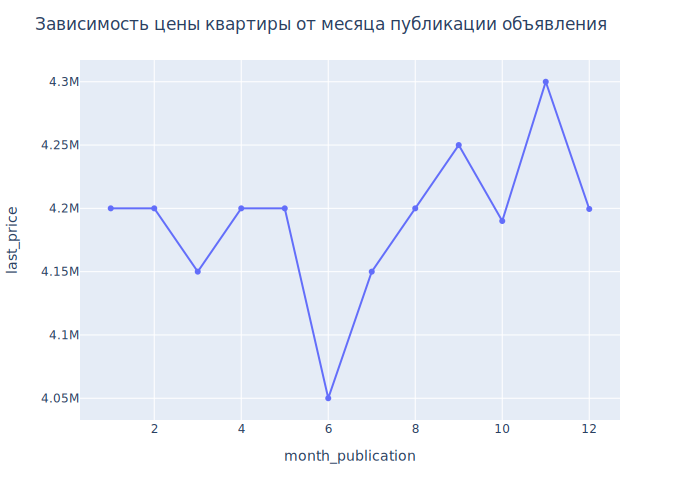

In [42]:
fig = px.scatter(df.groupby('month_publication')['last_price'].median().reset_index(),
                 x='month_publication', y='last_price')

fig.update_traces(mode='lines+markers')
fig.update_layout(title='Зависимость цены квартиры от месяца публикации объявления')
fig.show()

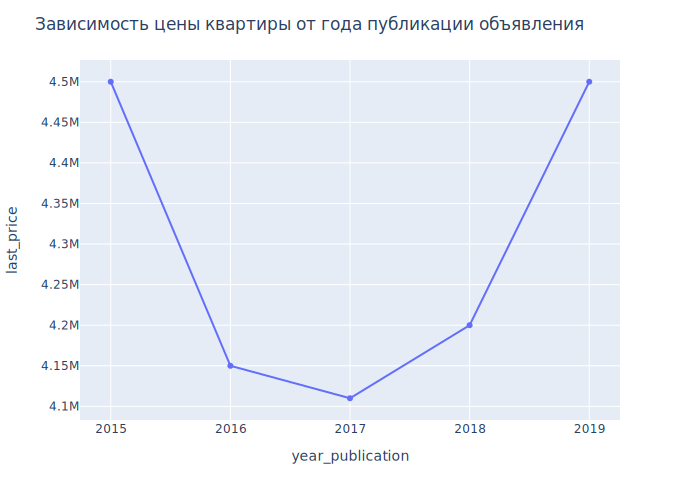

In [43]:
fig = px.scatter(df.groupby('year_publication')['last_price'].median().reset_index(),
                 x='year_publication', y='last_price')

fig.update_traces(mode='lines+markers')
fig.update_layout(title='Зависимость цены квартиры от года публикации объявления',
                  xaxis = dict(
                      tickvals = [2015,2016,2017,2018,2019]
                  ))
fig.show()

Не сказать, что дата размещения может влиять на стоимость квартиры

Делаем тепловую карту.

In [44]:
df_for_corr = df.loc[:, ['last_price', 'total_area', 'rooms', 'cityCenters_nearest', 'day_publication', 'month_publication', 'year_publication']]

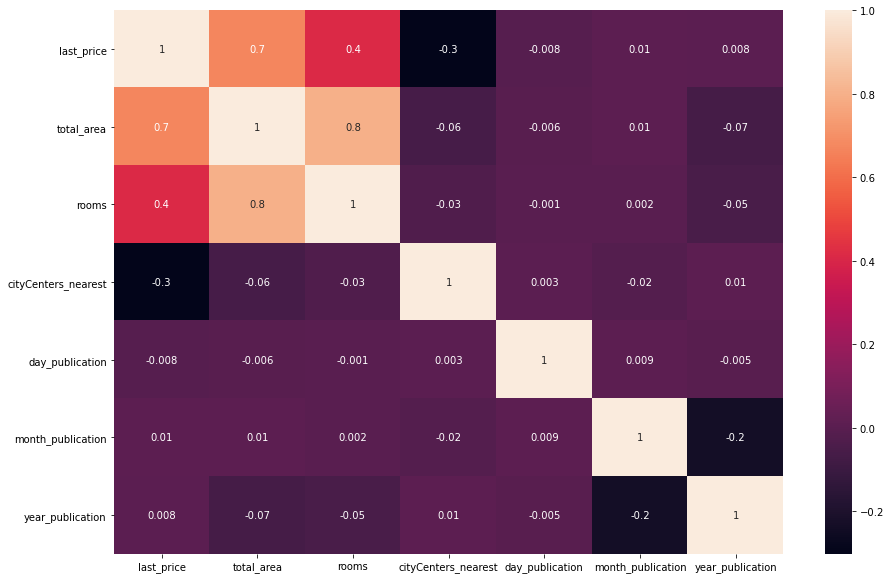

In [45]:
plt.subplots(figsize=(15,10))
sns.heatmap(df_for_corr.corr(), annot = True, fmt='.1g')
plt.show()

### Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите среди них населённые пункты с самой высокой и низкой стоимостью жилья.


In [46]:
locality_name_stat = (
    df
        .groupby('locality_name')['price_per_meter']
        .agg(['count', 'mean'])
        .sort_values(by='count', ascending=False)
        .head(10)
        .rename(columns={'mean':'price_per_meter_mean'})
)

locality_name_stat

count  price_per_meter_mean
locality_name                                 
Санкт-Петербург     9558         103038.593880
посёлок Мурино       444          85418.638586
посёлок Шушары       365          77546.481344
Всеволожск           281          66434.033872
посёлок Парголово    275          89397.587087
Колпино              270          74633.727627
деревня Кудрово      246          92451.184917
Пушкин               232          98783.981104
Гатчина              222          67906.582776
Выборг               170          57079.081261

Больше всего объявлений в Санкт-Петербурге (9558), меньше всего в Выборге (170)

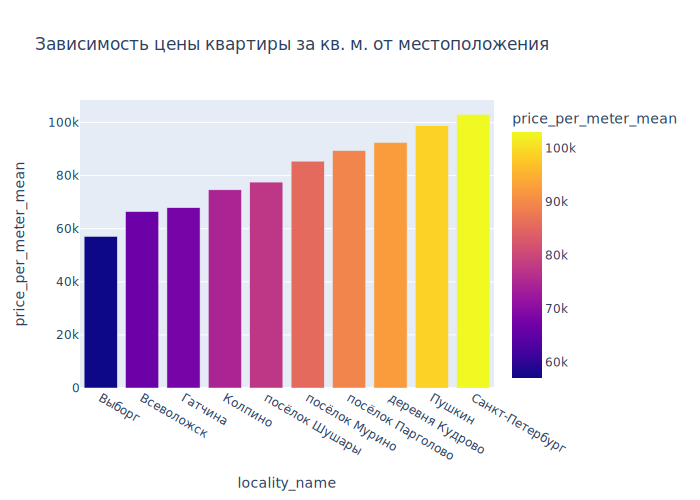

In [47]:
fig = px.bar(locality_name_stat.sort_values(by='price_per_meter_mean').reset_index(),
             x='locality_name', y='price_per_meter_mean',
             title='Зависимость цены квартиры за кв. м. от местоположения',
             color='price_per_meter_mean')
fig.show()

В Санкт-Петербурге самая высокая стоимость жилья, в Выборге самая низкая.

### Изучите предложения квартир: выделите квартиры в Санкт-Петербурге. Ваша задача — выяснить, какая область входит в центр. 

Выделим в отдельный датафрейм данные о квартирах только в Санкт-Петербурге и добавим новый столбец, где рассчитаем отдаленность квартиры от центра в км

In [48]:
df_spb = df.query('locality_name == "Санкт-Петербург"')
df_spb['km_to_center'] = np.ceil(df['cityCenters_nearest'] / 1000)
df_spb

last_price  total_area  kitchen_area  living_area  ceiling_height  \
5       8780000.0        78.3          11.0         51.0            2.50   
15      7700000.0        85.0          11.0         50.0            2.70   
29      6800000.0        81.1          15.1         45.1            2.70   
38      8400000.0        85.0           9.5         48.5            2.65   
39      9900000.0        89.0          14.5         60.0            2.50   
...           ...         ...           ...          ...             ...   
23599   5499000.0        50.0           8.0         31.0            2.60   
23603   5000000.0        57.0           6.0         42.0            2.60   
23604   7100000.0        56.0           9.0         30.8            2.60   
23610   4750000.0        51.0           6.9         32.7            2.60   
23611   4250000.0        47.0          14.6         18.2            2.60   

       floor  floors_total  rooms  days_exposition first_day_exposition  \
5          9            15      3               31           2018-08-24   
15         1            10      3               50           2019-02-07   
29         9            16      4               60           2017-12-08   
38         5            12      3                4           2017-04-24   
39        11            16      2              113           2018-07-04   
...      ...           ...    ...              ...                  ...   
23599      8             9      2               37           2018-12-18   
23603      4             9      3               28           2017-07-01   
23604      5             6      2              136           2017-04-21   
23610      5             9      2               13           2018-09-08   
23611      1             6      1              131           2016-05-20   

         locality_name  cityCenters_nearest  price_per_meter  day_publication  \
5      Санкт-Петербург              16333.0    112132.822478                4   
15     Санкт-Петербург              14719.0     90588.235294                3   
29     Санкт-Петербург              15766.0     83847.102343                4   
38     Санкт-Петербург               9361.0     98823.529412                0   
39     Санкт-Петербург              13445.0    111235.955056                2   
...                ...                  ...              ...              ...   
23599  Санкт-Петербург              13321.0    109980.000000                1   
23603  Санкт-Петербург              14970.0     87719.298246                5   
23604  Санкт-Петербург               4578.0    126785.714286                4   
23610  Санкт-Петербург              16596.0     93137.254902                5   
23611  Санкт-Петербург               4946.0     90425.531915                4   

       month_publication  year_publication    floor_str  \
5                      8              2018  Другой этаж   
15                     2              2019  Первый этаж   
29                    12              2017  Другой этаж   
38                     4              2017  Другой этаж   
39                     7              2018  Другой этаж   
...                  ...               ...          ...   
23599                 12              2018  Другой этаж   
23603                  7              2017  Другой этаж   
23604                  4              2017  Другой этаж   
23610                  9              2018  Другой этаж   
23611                  5              2016  Первый этаж   

       living_to_total_ratio  kitchen_to_total_ratio  km_to_center  
5                       0.65                    0.14          17.0  
15                      0.59                    0.13          15.0  
29                      0.56                    0.19          16.0  
38                      0.57                    0.11          10.0  
39                      0.67                    0.16          14.0  
...                      ...                     ...           ...  
23599                   0.62

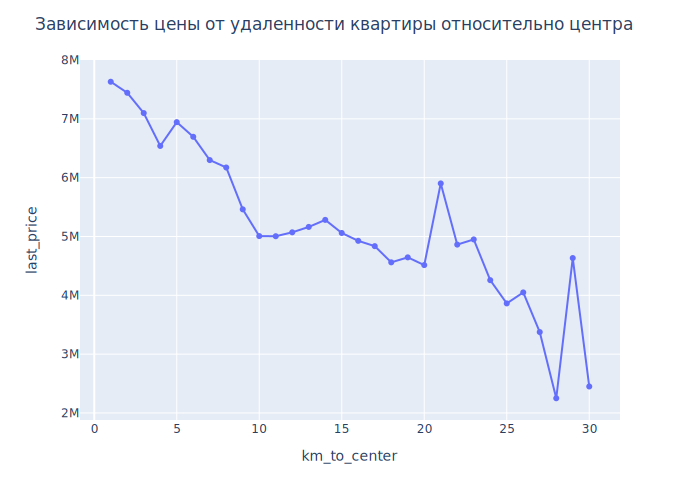

In [49]:
fig = px.scatter(df_spb.groupby('km_to_center')['last_price'].mean().reset_index(),
                 x='km_to_center', y='last_price')

fig.update_traces(mode='lines+markers')
fig.update_layout(title='Зависимость цены от удаленности квартиры относительно центра')
fig.show()

Судя по графику, центральная зона - это в пределах 8 км - дальше график сильно проседает

### Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

Мы решили, что центр города - это в пределах 8 км. Выделим эти квартиры

In [50]:
df_spb_center = df_spb.query('cityCenters_nearest <= 8000')

И еще выделим в отдельный датафрейм данные о квартирах **не** в центре для дальнейшего сравнения

In [51]:
df_spb_not_center = df_spb.query('cityCenters_nearest > 8000')

Изучим площадь.

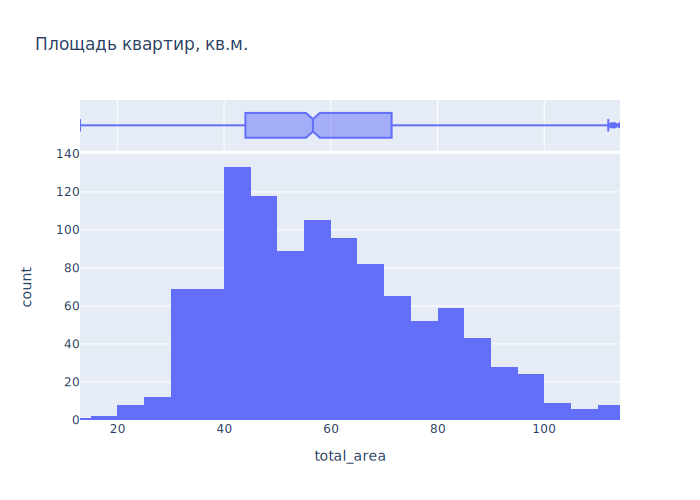

total_area
count  1078.000000
mean     58.648970
std      19.012969
min      13.000000
25%      44.000000
50%      56.650000
75%      71.300000
max     114.200000

In [52]:
primary_info(df_spb_center, 'total_area', 'Площадь квартир, кв.м.')

In [53]:
pd.DataFrame(df_spb_not_center['total_area'].describe())

total_area
count  8466.000000
mean     50.442142
std      15.814406
min      14.000000
25%      38.400000
50%      46.100000
75%      60.000000
max     114.000000

В центре города у квартир в среднем площадь больше на 9-10 кв.м., чем по городу в целом.

Посмотрим цены.

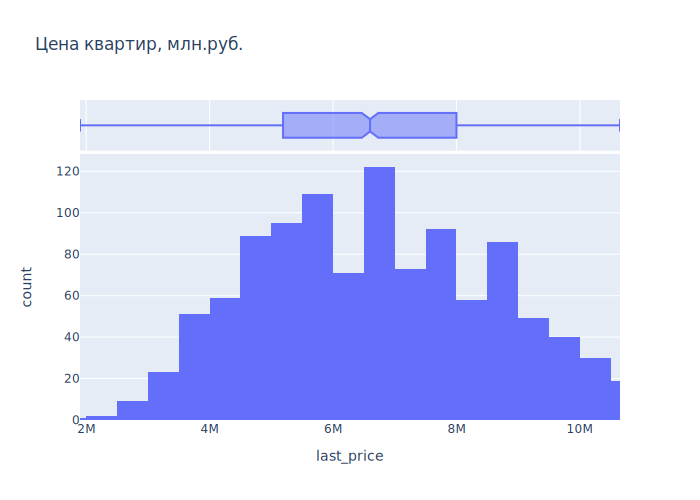

last_price
count  1.078000e+03
mean   6.645429e+06
std    1.897648e+06
min    1.900000e+06
25%    5.190000e+06
50%    6.600000e+06
75%    8.000000e+06
max    1.065000e+07

In [54]:
primary_info(df_spb_center, 'last_price', 'Цена квартир, млн.руб.')

In [55]:
pd.DataFrame(df_spb_not_center['last_price'].describe())

last_price
count  8.466000e+03
mean   5.024378e+06
std    1.638002e+06
min    1.190000e+06
25%    3.800000e+06
50%    4.600000e+06
75%    5.865000e+06
max    1.069000e+07

In [56]:
df_spb_center['last_price'].mean() / df_spb_not_center['last_price'].mean()

1.3226370684105284

Что и логично, квартиры в центре на 30% дороже, чем по городу в целом.

Посмотрим, что с комнатами.

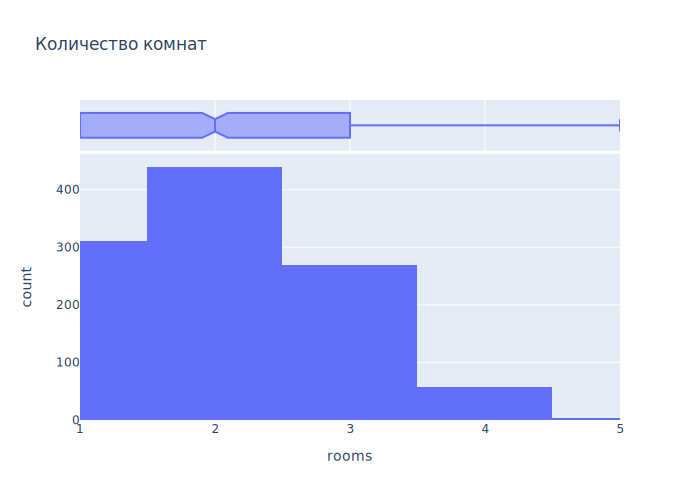

rooms
count  1078.000000
mean      2.076067
std       0.876688
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       5.000000

In [57]:
primary_info(df_spb_center, 'rooms', 'Количество комнат')

In [58]:
pd.DataFrame(df_spb_not_center['rooms'].describe())

rooms
count  8466.000000
mean      1.851642
std       0.848867
min       1.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       5.000000

По комнатам квартиры почти ничем не отличаются. 1-2 комнатные, чуть реже - 3.

Высота потолков.

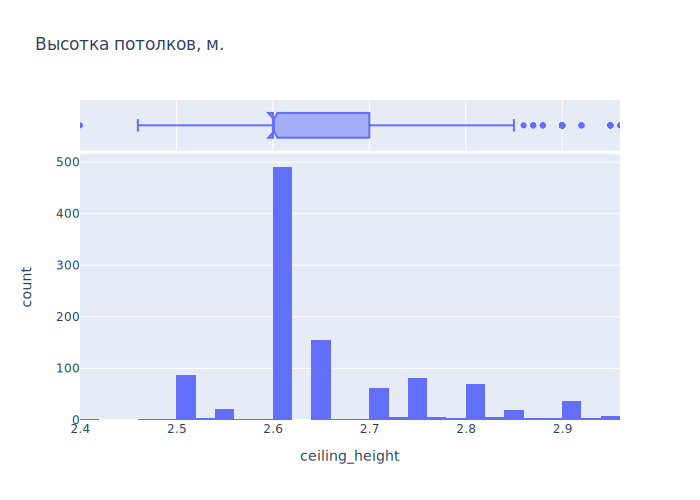

ceiling_height
count     1078.000000
mean         2.650761
std          0.100833
min          2.400000
25%          2.600000
50%          2.600000
75%          2.700000
max          2.960000

In [59]:
primary_info(df_spb_center, 'ceiling_height', 'Высотка потолков, м.')

In [60]:
pd.DataFrame(df_spb_not_center['ceiling_height'].describe())

ceiling_height
count     8466.000000
mean         2.632406
std          0.094810
min          2.400000
25%          2.550000
50%          2.600000
75%          2.700000
max          2.960000

Разница в высоте потолков в центре и по городу незначительна.

In [61]:
df_for_corr = df_spb_center.loc[:, ['last_price', 'total_area', 'rooms', 'cityCenters_nearest', 'day_publication', 'month_publication', 'year_publication']]

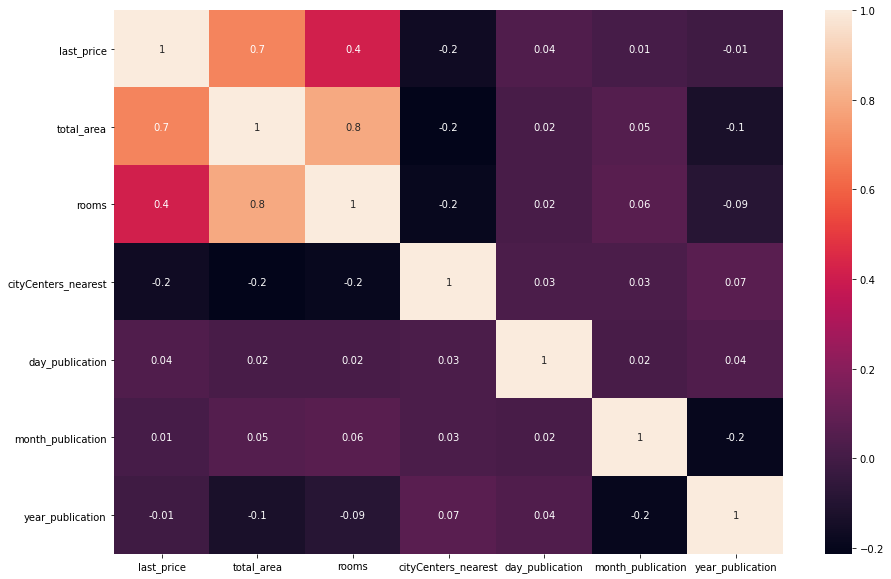

In [62]:
plt.subplots(figsize=(15,10))
sns.heatmap(df_for_corr.corr(), annot = True, fmt='.1g')
plt.show()

Пишем функцию построения двух графиков для сравнения параметров в центре и по городу.

In [63]:
def plot_line(column, label):
  dr1 = df_spb_not_center.groupby(column)['last_price'].median().reset_index()
  dr2 = df_spb_center.groupby(column)['last_price'].median().reset_index()

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=dr1[column], y=dr1['last_price'], name='Цена по городу'))
  fig.add_trace(go.Scatter(x=dr2[column], y=dr2['last_price'], name='Цена в центре'))

  fig.update_layout(title=label,
                    xaxis_title=column,
                    yaxis_title='last_price')

  fig.show()

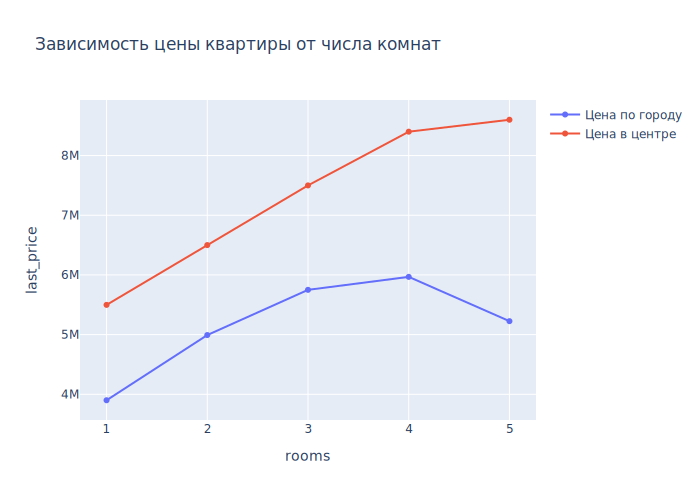

In [64]:
plot_line('rooms', 'Зависимость цены квартиры от числа комнат')

Здесь различие только в том, что квартиры в центре дороже

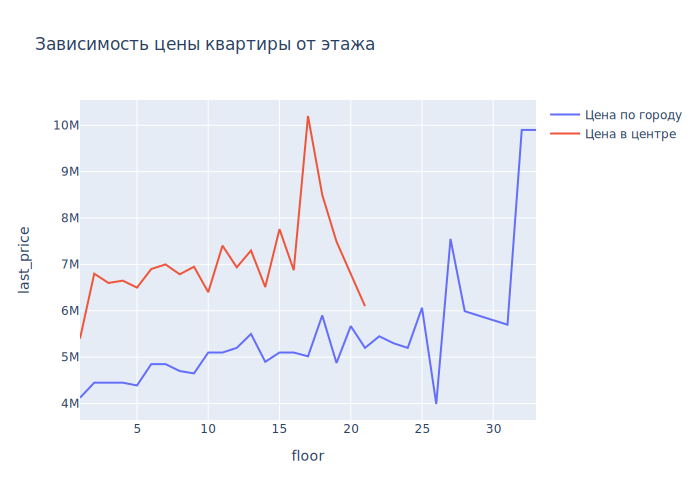

In [65]:
plot_line('floor', 'Зависимость цены квартиры от этажа')

Здесь ситуация аналогичная, но можно заметить, что в центре максимальная этажность дома - 21, а по городу - 33 

Посмотрим на дату.

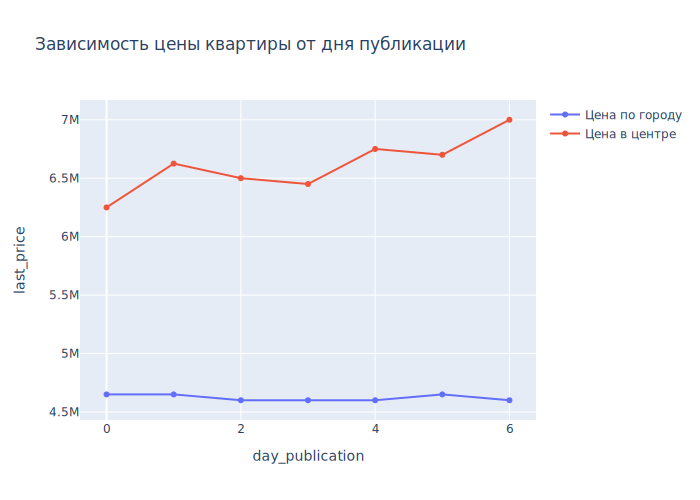

In [66]:
plot_line('day_publication', 'Зависимость цены квартиры от дня публикации')

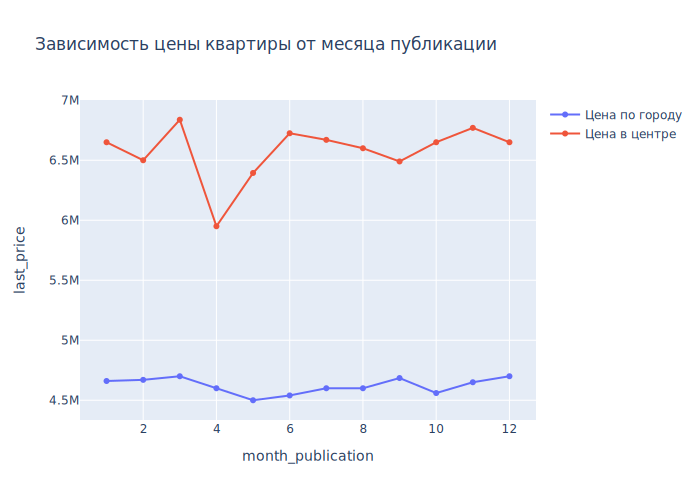

In [67]:
plot_line('month_publication', 'Зависимость цены квартиры от месяца публикации')

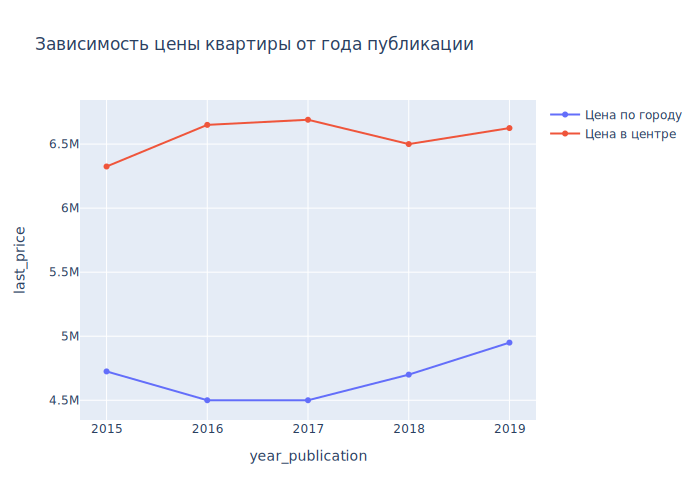

In [68]:
plot_line('year_publication', 'Зависимость цены квартиры от года публикации')

Графики почти идентичны, с той лишь разницей, что в центре цены больше.

# Общий вывод

*Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры.*

**Факторы, влияющие на стоимость квартиры:**
1. Площадь. Логично, что чем больше площадь квартиры, тем больше стоимость.
2. Количество комнат. Такая же ситуация.
3. Удаленность от центра. Отрицательная корреляция - чем дальше от центра, в нашем случае это 8 км, тем дешевле квартира.
4. Этаж квартиры. Первые и последние этажи уменьшают стоимость недвижимости.
5. В среднем квартиры продаются за 2 месяца.

**Ход работы:**
1. Прочитали и сохранили данные.
2. Выполнили предобработку данных.
3. Расчитали промежуточные данные и добавили их в таблицу.
4. Провели исследовательский анализ данных: изучили ценообразующие параметры, очистили данные от выбросов.
5. Общий вывод.